# VGG16 – Convolutional Network for Classification and Detection

In [1]:
# Import TensorFlow
%tensorflow_version 2.x
import tensorflow as tf

# Import Keras
from tensorflow import keras

# Allows us to work with files and folders
import os
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
2.2.0


## Load pre-trained Model

In [2]:
# Load a pre-trained model from VGG16
from tensorflow.keras.applications import vgg16, VGG16

# Load pre-trained model
#vgg_model = vgg16.VGG16(weights='imagenet')                                    # pre-training on ImageNet (http://www.image-net.org/)
                                                                                # most images are in 256x256 pixels
# Load pre-trained model with specific parameters for our case and data
vgg_model = VGG16(input_shape = (150, 150, 3),                                  # Optional shape tuple, only to be specified if include_top is False
                          include_top = False,                                  # Prevents the loading of the fully-connected layer at the top of the network
                          weights = 'imagenet')                                 # pre-training on ImageNet

# Preview the Neural Network and its structure
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Prepare the new Model

In [3]:
# Freeze the layers of the part of the model that corresponds to the convolutional neural network
for layer in vgg_model.layers:
  layer.trainable = False

# The pre-trained model is now not trainable anymore
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
#from keras.callbacks import EarlyStopping                                      # EarlyStopping to prevent Over Fitting
#from keras import regularizers                                                 # Regularizers 

# Build model
model_feature_extraction = Sequential()

# Add the pre-trained model (layers) to our layers
model_feature_extraction.add(vgg_model)

## OUR OWN MODEL ## 
# Create our model
#model_feature_extraction = tf.keras.Sequential()

# Flattens the input
model_feature_extraction.add(Flatten())

# Classification layer
model_feature_extraction.add(Dense(512,                                         # Connects to 512 neurons
                activation = 'relu'))
# OUTPUT LAYER
model_feature_extraction.add(Dense(1,
                activation = 'sigmoid'))                                        # sigmoid function converts the data to be (binary) between 0 and 1

# Summary of the model
model_feature_extraction.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


## Prepare new training, validation, and test data

In [5]:
# Allows us to work with Files
from google.colab import files

# To unzip our ZIP file
import zipfile

# Connects to GoogleDrive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Download data
# SOURCE: https://www.kaggle.com/slothkong/10-monkey-species

# Label,  Latin Name           , Common Name                   , Train Images , Validation Images
# n0   , alouatta_palliata	 , mantled_howler                , 131          , 26
# n1   , erythrocebus_patas	 , patas_monkey                  , 139          , 28

In [0]:
# Unzip
import os
import zipfile
# Training data
local_zip = '/content/drive/My Drive/Colab Notebooks/BAnalytics/training.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
# Validation data
local_zip = '/content/drive/My Drive/Colab Notebooks/BAnalytics/validation.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
# Test data (from Google)
local_zip = '/content/drive/My Drive/Colab Notebooks/BAnalytics/test.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
# Remove unnecessary folders to simplify training data and classification model (2 classes)
# Training
!rm -rf "/tmp/training/n2"
!rm -rf "/tmp/training/n3"
!rm -rf "/tmp/training/n4"
!rm -rf "/tmp/training/n5"
!rm -rf "/tmp/training/n6"
!rm -rf "/tmp/training/n7"
!rm -rf "/tmp/training/n8"
!rm -rf "/tmp/training/n9"
# Validation
!rm -rf "/tmp/validation/n2"
!rm -rf "/tmp/validation/n3"
!rm -rf "/tmp/validation/n4"
!rm -rf "/tmp/validation/n5"
!rm -rf "/tmp/validation/n6"
!rm -rf "/tmp/validation/n7"
!rm -rf "/tmp/validation/n8"
!rm -rf "/tmp/validation/n9"

In [9]:
# Declare the paths of the images
base_dir = '/tmp/'

# train folder
train_dir = os.path.join(base_dir, 'training')

# validation folder
validation_dir = os.path.join(base_dir, 'validation')

# test folder
test_dir = os.path.join(base_dir, 'test')

# Training images folder
train_mantled_howler_dir = os.path.join(train_dir, 'n0') # mantled_howler
train_patas_monkey_dir = os.path.join(train_dir, 'n1') # patas_monkey

validation_mantled_howler_dir = os.path.join(validation_dir, 'n0') # mantled_howler
validation_patas_monkey_dir = os.path.join(validation_dir, 'n1') # patas_monkey

test_mantled_howler_dir = os.path.join(test_dir, 'n0') # mantled_howler
test_patas_monkey_dir = os.path.join(test_dir, 'n1') # patas_monkey

# Check how many classes we have in each folder
print('Total number of Mantled Howler images in training:', len(os.listdir(train_mantled_howler_dir)))
print('Total number of Bald Uakari images in training:', len(os.listdir(train_patas_monkey_dir)))
print('Total number of Mantled Howler images in validation:', len(os.listdir(validation_mantled_howler_dir)))
print('Total number of Bald Uakari images in validation:', len(os.listdir(validation_patas_monkey_dir)))
print('Total number of Mantled Howler images in test:', len(os.listdir(test_mantled_howler_dir)))
print('Total number of Bald Uakari images in test:', len(os.listdir(test_patas_monkey_dir)))

Total number of Mantled Howler images in training: 105
Total number of Bald Uakari images in training: 111
Total number of Mantled Howler images in validation: 26
Total number of Bald Uakari images in validation: 28
Total number of Mantled Howler images in test: 7
Total number of Bald Uakari images in test: 6


## Review Data

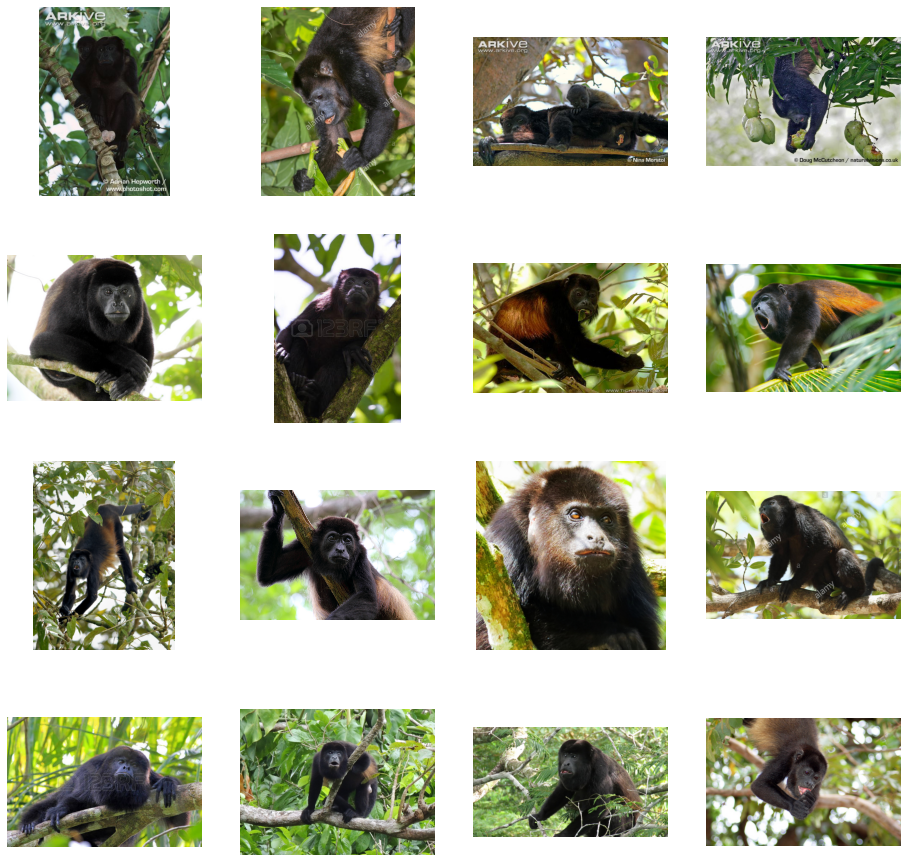

In [10]:
# For visualization purposes
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

nrows = 4
ncols = 4

# Create an index to iterative over our images
pic_index = 0
fig = plt.gcf()                                                                 # image layers
fig.set_size_inches(nrows*4, ncols*4)                                           # total image size

for i in range(0, 16):  # 16 images
  random_cat = os.path.join(train_mantled_howler_dir, os.listdir(train_mantled_howler_dir)[random.randint(1, len(os.listdir(train_mantled_howler_dir)))])  # select a random file inside the train_cats_dir folder
  # Access the subplot inside the fig
  sp = plt.subplot(nrows, ncols, i + 1)
  # Eleminate axis of the subplot, for better visualization
  sp.axis('Off')
  img = mpimg.imread(random_cat)
  plt.imshow(img)
plt.show()

## Compile new Model

In [0]:
from tensorflow.keras.optimizers import RMSprop

# Optimizer for our model
optimizer = RMSprop(lr = 0.001)                                                 # Learning rate

# Compile our model
model_feature_extraction.compile(optimizer = optimizer, 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])                                                # accuracy

## Prepare Data and new Model parameters

In [12]:
# Create a generator to prepare our input data (images)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescaling our images, 
# and applying Data Augmentation (creating new and more data inputs)
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,                       # All images divided by 255 pixels, to normalize the data between 0 and 1
                                   rotation_range = 40,                         # Data Augmentation: rotating the images randomly
                                   width_shift_range = 0.2,                     # Moves random images in width
                                   height_shift_range = 0.2,                    # Moves random images in height
                                   shear_range = 0.2,                           # Deforms random images
                                   zoom_range = 0.2,                            # Zooms into the images randomly
                                   horizontal_flip = 'TRUE')                      # Flips horizontally random images

validation_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)

test_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)

# Rescale our training data (images)
train_generator = train_datagen.flow_from_directory(train_dir,                  # Folder
                                                    batch_size = 20,            # Loads 20 images iteratively
                                                    class_mode = 'binary',      # Divides the data into 2 classes (mantled_howler and patas_monkey)
                                                    target_size = (150, 150))   # Rescales the images to 150 by 150

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150)) 

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150)) 

print('Our classes are:', train_generator.class_indices)
# This will reshape and distort some images – which shows the importance of having normalized and clean data beforehand (but nothing is perfect)

Found 216 images belonging to 2 classes.
Found 54 images belonging to 2 classes.
Found 12 images belonging to 2 classes.
Our classes are: {'n0': 0, 'n1': 1}


In [0]:
# Calculate how many steps are we going to make per epoch
batch_size = 20

steps_per_epoch = train_generator.n//batch_size

validation_steps = validation_generator.n//batch_size

In [14]:
# Using fit_generator (.fit) because our data has 3 dimensions, but it will be depreceated in the near future
trained_model = model_feature_extraction.fit_generator(train_generator,
                                    steps_per_epoch = steps_per_epoch, 
                                    epochs = 15,
                                    validation_data = validation_generator,
                                    validation_steps = validation_steps,
                                    verbose = 2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
10/10 - 7s - loss: 3.1890 - acc: 0.5663 - val_loss: 0.2457 - val_acc: 0.9500
Epoch 2/15
10/10 - 6s - loss: 0.8098 - acc: 0.6173 - val_loss: 0.2223 - val_acc: 0.9250
Epoch 3/15
10/10 - 6s - loss: 0.2424 - acc: 0.8929 - val_loss: 0.2199 - val_acc: 0.9000
Epoch 4/15
10/10 - 6s - loss: 0.3298 - acc: 0.8469 - val_loss: 0.1807 - val_acc: 0.9250
Epoch 5/15
10/10 - 6s - loss: 0.2160 - acc: 0.9286 - val_loss: 0.1145 - val_acc: 0.9500
Epoch 6/15
10/10 - 6s - loss: 0.1630 - acc: 0.9490 - val_loss: 0.3009 - val_acc: 0.9000
Epoch 7/15
10/10 - 6s - loss: 0.3179 - acc: 0.8776 - val_loss: 0.1887 - val_acc: 0.9250
Epoch 8/15
10/10 - 6s - loss: 0.2151 - acc: 0.9235 - val_loss: 0.2020 - val_acc: 0.9750
Epoch 9/15
10/10 - 6s - loss: 0.0876 - acc: 0.9694 - val_loss: 0.0506 - val_acc: 0.9750
Epoch 10/15
10/10 - 6s - loss: 0.1659 - acc: 0.9388 - val_loss: 0.0408 - val_acc: 1.0000
Epoch 11/15
10/10 - 6s - loss: 0.1762 - acc

### Evaluate our Model

<Figure size 432x288 with 0 Axes>

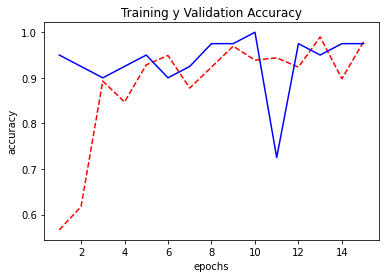

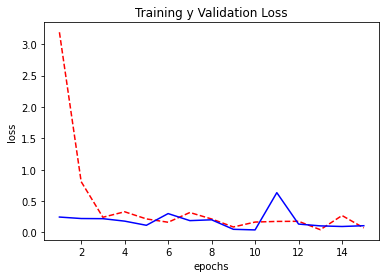

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

acc = trained_model.history['acc']
validation_acc = trained_model.history['val_acc']
loss = trained_model.history['loss']
validation_loss = trained_model.history['val_loss']

epochs = range(1, len(acc) + 1, 1)

plt.plot(epochs, acc, 'r--', label = 'Training Accuracy')
plt.plot(epochs, validation_acc, 'b', label = 'Validation Accuracy')
plt.title('Training y Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.figure()

plt.plot(epochs, loss, 'r--', label = 'Training Loss')
plt.plot(epochs, validation_loss, 'b', label = 'Validation Loss')
plt.title('Training y Validation Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.figure()

In [16]:
# Evaluate model
val_loss, val_acc = model_feature_extraction.evaluate(validation_generator)

print('Validation accuracy: ' + '{:.2%}'.format(val_acc))

3/3 [==============================] - 2s 637ms/step - loss: 0.0856 - acc: 0.9815
Validation accuracy: 98.15%


## Test our new Model

Saving this_is_a_test.jpeg to this_is_a_test.jpeg

The class is [[1.]], meaning that the animal is a patas_monkey.


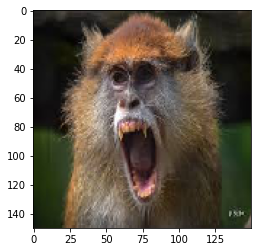

In [18]:
import numpy as np
#from google.colab import files
from tensorflow.keras.preprocessing import image

# Upload a new image file
uploaded = files.upload()

# Select first element
file = list(uploaded.keys())[0]

# From our Google Drive folder
path = '/content/' + file

# Scale the image
img = image.load_img(path, target_size = (150, 150))

# Converts the image to an array
x = image.img_to_array(img)

# Preprocessing of the image
image = np.expand_dims(x, axis = 0)

# Predict if it is a mantled_howler(= 0) or a patas_monkey(= 1)
classes = model_feature_extraction.predict(image)
if classes > 0:
  # patas_monkey = 1
  class_answer = 'patas_monkey'
else:
  # mantled_howler = 0
  class_answer = 'mantled_howler'
print(f'\nThe class is {classes}, meaning that the animal is a {class_answer}.')

# Show image
plt.imshow(img)
plt.show()